# FactorResearch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import cvxopt as opt
from cvxopt import blas, solvers

In [205]:
# load data
data_dir = 'quant_challenge/'
file_data = 'quant_challenge.csv'
file_turnoover = 'quant_challenge_turnover.csv'
raw_data = pd.read_csv(data_dir + file_data)
raw_data['date'] =  [datetime.strptime(str(item), '%Y%m%d').strftime('%m/%d/%Y')\
					 for item in raw_data['tradedate'].values] 
raw_data['date'] = pd.to_datetime(raw_data['date'], infer_datetime_format=True)
raw_data = raw_data.sort_values(by=['date']).drop_duplicates()
print(raw_data.head())
# info of each column
scoreids = list( set(raw_data['scoreid']) )
segmentids = list( set(raw_data['segmentid']) )
quantiles = list( set(raw_data['quantile']) )
n_scoreid = len(scoreids)
n_segmentid = len(segmentids)
n_quantile = len(quantiles)
print('scoreids', scoreids)
print('segmentids', segmentids)
print('quantiles', quantiles)

    tradedate  scoreid  segmentid  quantile    log_rt       date
0    19950105      102       1010         1  0.008387 1995-01-05
30   19950105      102       1016         1  0.003059 1995-01-05
31   19950105      102       1016         2 -0.000514 1995-01-05
32   19950105      102       1016         3  0.003668 1995-01-05
33   19950105      102       1016         4  0.005039 1995-01-05
scoreids [224, 222, 102]
segmentids [1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020]
quantiles [1, 2, 3, 4, 5]


## 0. outlook of data

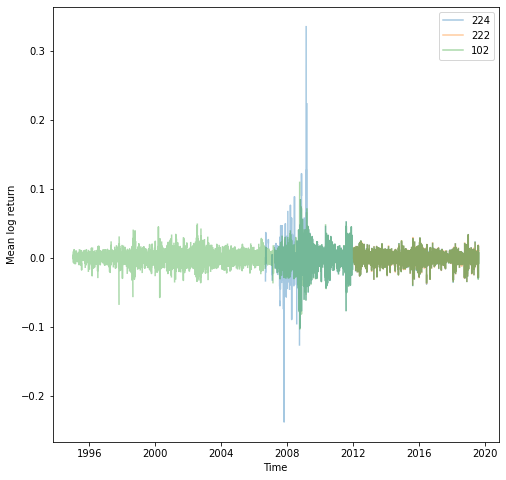

In [207]:
# question not covered in 2006-2008
# the overall return changing with time
data_224 = raw_data.loc[raw_data['scoreid'] == 224]
data_222 = raw_data.loc[raw_data['scoreid'] == 222]
data_102 = raw_data.loc[raw_data['scoreid'] == 102]

data_224_mean = data_224.groupby(pd.Grouper(key='date', axis=0, freq='D'))['log_rt'].mean()
data_222_mean = data_222.groupby(pd.Grouper(key='date', axis=0, freq='D'))['log_rt'].mean()
data_102_mean = data_102.groupby(pd.Grouper(key='date', axis=0, freq='D'))['log_rt'].mean()
%matplotlib inline 
#inline
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(data_224_mean, alpha=0.4, label='224')
ax.plot(data_222_mean, alpha=0.4, label='222')
ax.plot(data_102_mean, alpha=0.4, label='102')
ax.set_ylabel('Mean log return')
ax.set_xlabel('Time')
ax.legend()

plt.show()

In [25]:
print(data_224.loc[data_224['date'] == '2007-10-30'])
print(data_224.loc[data_224['date'] == '2008-10-31'])

        tradedate  scoreid  segmentid  quantile    log_rt       date
177797   20071030      224       1019         1  0.007214 2007-10-30
        tradedate  scoreid  segmentid  quantile    log_rt       date
195057   20081031      224       1010         1  0.013148 2008-10-31
195058   20081031      224       1010         2 -0.002075 2008-10-31
195059   20081031      224       1010         3  0.001140 2008-10-31
195060   20081031      224       1010         4  0.003468 2008-10-31
195061   20081031      224       1010         5 -0.002883 2008-10-31
195062   20081031      224       1011         1 -0.014012 2008-10-31
195063   20081031      224       1011         2 -0.011335 2008-10-31
195064   20081031      224       1011         3 -0.041851 2008-10-31
195065   20081031      224       1011         4 -0.034385 2008-10-31
195066   20081031      224       1011         5 -0.022784 2008-10-31
195067   20081031      224       1012         1  0.012451 2008-10-31
195068   20081031      224       1

## 1. clean data

In [22]:
# remove days with with missing values
data_cleaned = raw_data[raw_data.groupby(['scoreid', 'date']).date.transform('count')==55].copy() 
data_cleaned.to_csv('cleaned_quant_challenge.csv')
print(raw_data.shape, data_cleaned.shape)

(597607, 6) (597080, 6)


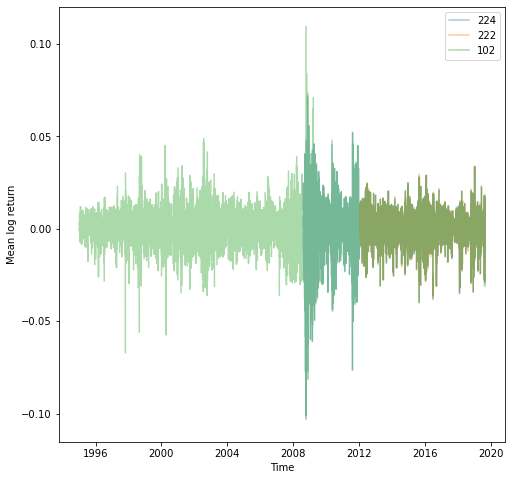

In [208]:
data_224 = data_cleaned.loc[data_cleaned['scoreid'] == 224]
data_222 = data_cleaned.loc[data_cleaned['scoreid'] == 222]
data_102 = data_cleaned.loc[data_cleaned['scoreid'] == 102]

data_224_mean = data_224.groupby(pd.Grouper(key='date', axis=0, freq='D'))['log_rt'].mean()
data_222_mean = data_222.groupby(pd.Grouper(key='date', axis=0, freq='D'))['log_rt'].mean()
data_102_mean = data_102.groupby(pd.Grouper(key='date', axis=0, freq='D'))['log_rt'].mean()
%matplotlib inline 
#inline widget
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(data_224_mean, alpha=0.4, label='224')
ax.plot(data_222_mean, alpha=0.4, label='222')
ax.plot(data_102_mean, alpha=0.4, label='102')
ax.set_ylabel('Mean log return')
ax.set_xlabel('Time')
ax.legend()

plt.show()

## 1a. Plot the stats of returns of each subgroup (scoreid, segmentid, quantile)

In [7]:
def select_data(scoreid, segmentid, quantile, data = data_cleaned):
	return(data.loc[(data['scoreid']==scoreid) & (data['segmentid'] == segmentid)
				   & (data['quantile'] == quantile)])

In [10]:
# Outlook of data
# cal stats
def data_stats(data):
	n_scoreid = len(scoreids)
	n_segmentid = len(segmentids)
	n_quantile = len(quantiles)
	stat_mean = np.zeros((n_scoreid, n_segmentid,n_quantile))
	stat_std = np.zeros((n_scoreid, n_segmentid,n_quantile))
	stat_med = np.zeros((n_scoreid, n_segmentid,n_quantile))

	for i in range(n_scoreid):
		for j in range(n_segmentid):
			for k in range(n_quantile):
				scoreid = scoreids[i]
				segmentid = segmentids[j]
				quantile = quantiles[k]
				data_selected = select_data(scoreid=scoreid, segmentid=segmentid, quantile=quantile, \
							   data = data)['log_rt'].values
				stat_mean[i,j,k] = np.mean(data_selected)
				stat_std[i,j,k] = np.std(data_selected)
				stat_med[i,j,k] = np.median(data_selected)
	return(stat_mean, stat_std, stat_med)

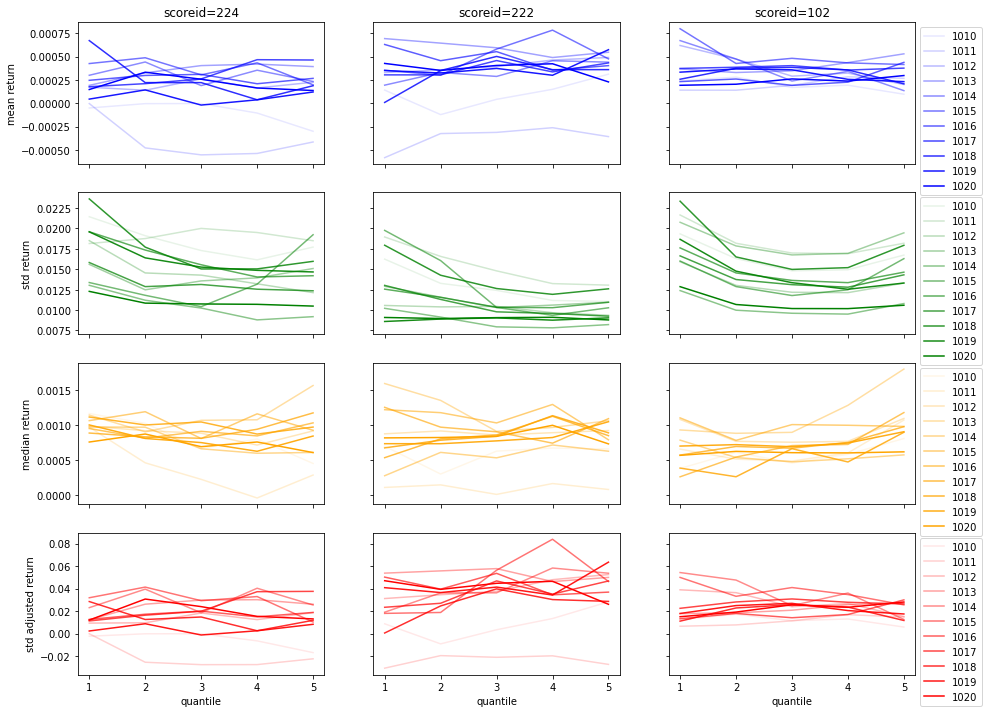

In [37]:
# plot the mean return of return vs quantile for all segments 
%matplotlib inline
#widget 
stat_mean, stat_std, stat_med = data_stats(data_cleaned)
fig,axs = plt.subplots(4,3,figsize=(15,12), sharey='row', sharex=True)
for i in range(n_scoreid):
	for j in range(n_segmentid):
		axs[0,i].plot(quantiles, stat_mean[i,j,:], label=segmentids[j], c = 'b', alpha = 1/n_segmentid*(j+1))
		axs[1,i].plot(quantiles, stat_std[i,j,:], label=segmentids[j], c = 'g', alpha = 1/n_segmentid*(j+1))
		axs[2,i].plot(quantiles, stat_med[i,j,:], label=segmentids[j], c = 'orange', alpha = 1/n_segmentid*(j+1))
		axs[3,i].plot(quantiles, stat_mean[i,j,:]/stat_std[i,j,:], label=segmentids[j], \
					  c = 'r', alpha = 1/n_segmentid*(j+1))
	axs[0,i].set_title('scoreid=%d'%scoreids[i])
	axs[3,i].set_xlabel('quantile')
axs[0,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[1,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[2,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[3,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[0,0].set_ylabel('mean return')
axs[1,0].set_ylabel('std return')
axs[2,0].set_ylabel('median return')
axs[3,0].set_ylabel('std adjusted return')

plt.show()

* scoreid=224: bad at some segments, low quantile high std;
* scoreid=222: bad at some segments, low quantile high std; good at high quantile, high std adjusted return; 
* scoreid=102: not that seneitive to segments;

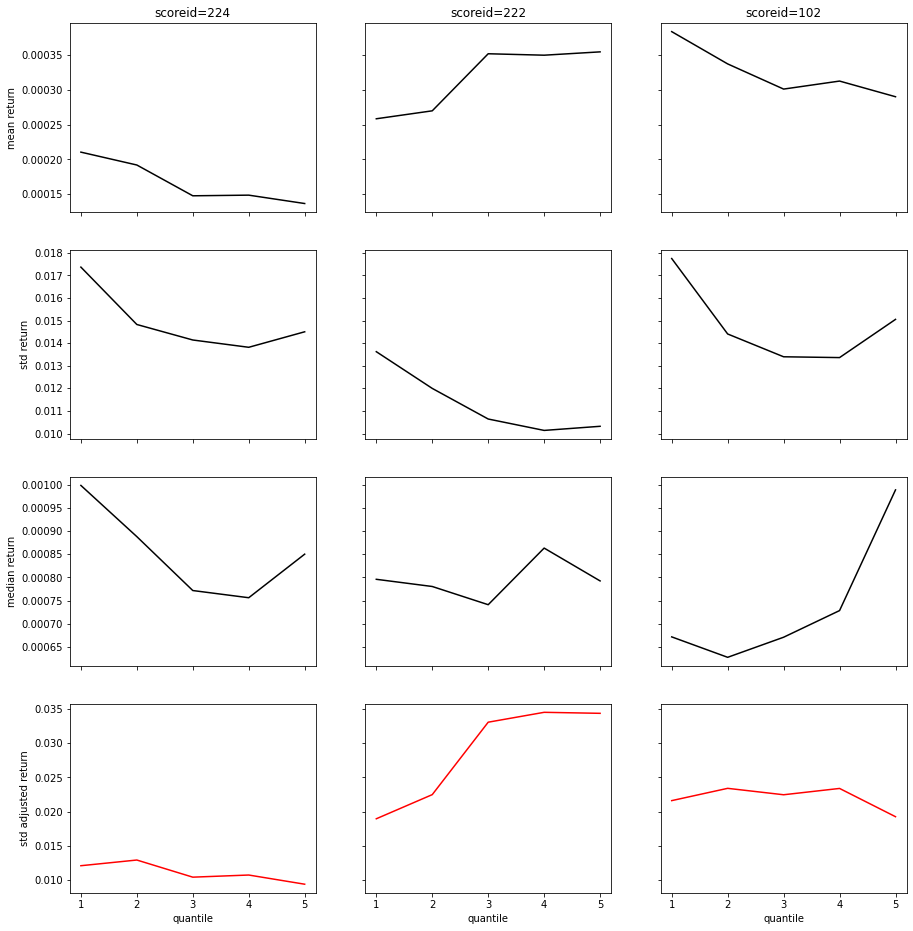

In [38]:
fig,axs = plt.subplots(4,3,figsize=(15,16), sharey='row', sharex=True)
for i in range(n_scoreid):
	axs[0,i].plot(quantiles, np.mean(stat_mean[i,:,:], axis=0), c = 'black')
	axs[1,i].plot(quantiles, np.mean(stat_std[i,:,:], axis=0),  c = 'black')
	axs[2,i].plot(quantiles, np.mean(stat_med[i,:,:], axis=0),  c = 'black')
	axs[3,i].plot(quantiles, np.mean(stat_mean[i,:,:], axis=0)/np.mean(stat_std[i,:,:], axis=0), c = 'red')
	axs[0,i].set_title('scoreid=%d'%scoreids[i])
	axs[3,i].set_xlabel('quantile')
axs[0,0].set_ylabel('mean return')
axs[1,0].set_ylabel('std return')
axs[2,0].set_ylabel('median return')
axs[3,0].set_ylabel('std adjusted return')

plt.show()

* scoreid=224: lowest mean return; high median retun at low quantile.
* scoreid=222: high mean return; lowest std; median is independent to quantile.
* scoreid=102: high mean return; large std; median is high at high quantile.

## the performance in the same period

In [23]:
data_sameperiod = data_cleaned[data_cleaned.groupby('date').date.transform('count')==55*3].copy() 
stat_mean, stat_std, stat_med = data_stats(data_sameperiod)

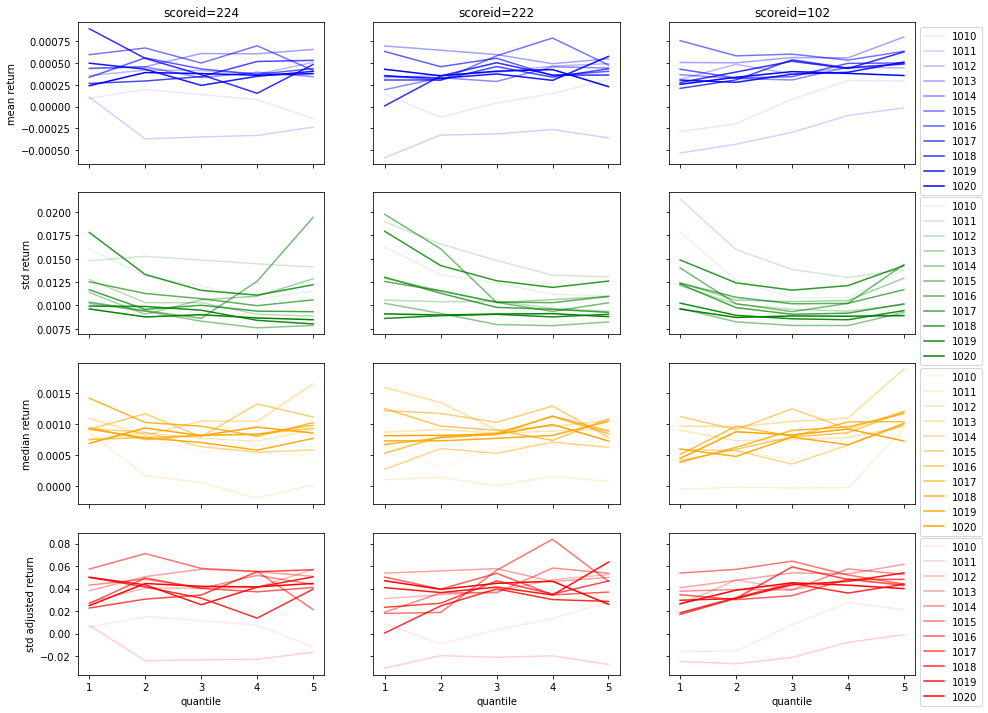

In [24]:
%matplotlib inline
#widget 
fig,axs = plt.subplots(4,3,figsize=(15,12), sharey='row', sharex=True)
for i in range(n_scoreid):
	for j in range(n_segmentid):
		axs[0,i].plot(quantiles, stat_mean[i,j,:], label=segmentids[j], c = 'b', alpha = 1/n_segmentid*(j+1))
		axs[1,i].plot(quantiles, stat_std[i,j,:], label=segmentids[j], c = 'g', alpha = 1/n_segmentid*(j+1))
		axs[2,i].plot(quantiles, stat_med[i,j,:], label=segmentids[j], c = 'orange', alpha = 1/n_segmentid*(j+1))
		axs[3,i].plot(quantiles, stat_mean[i,j,:]/stat_std[i,j,:], label=segmentids[j], \
					  c = 'r', alpha = 1/n_segmentid*(j+1))
	#axs[0,i].plot(quantiles, np.mean(stat_mean[i,:,:], axis=0), label='mean', c = 'black')
	#axs[1,i].plot(quantiles, np.mean(stat_std[i,:,:], axis=0), label='mean', c = 'black')
	#axs[2,i].plot(quantiles, np.mean(stat_med[i,:,:], axis=0), label='mean', c = 'black')
	axs[0,i].set_title('scoreid=%d'%scoreids[i])
	axs[3,i].set_xlabel('quantile')
axs[0,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[1,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[2,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[3,2].legend(bbox_to_anchor=(1.0, 1.0))
axs[0,0].set_ylabel('mean return')
axs[1,0].set_ylabel('std return')
axs[2,0].set_ylabel('median return')
axs[3,0].set_ylabel('std adjusted return')

plt.show()

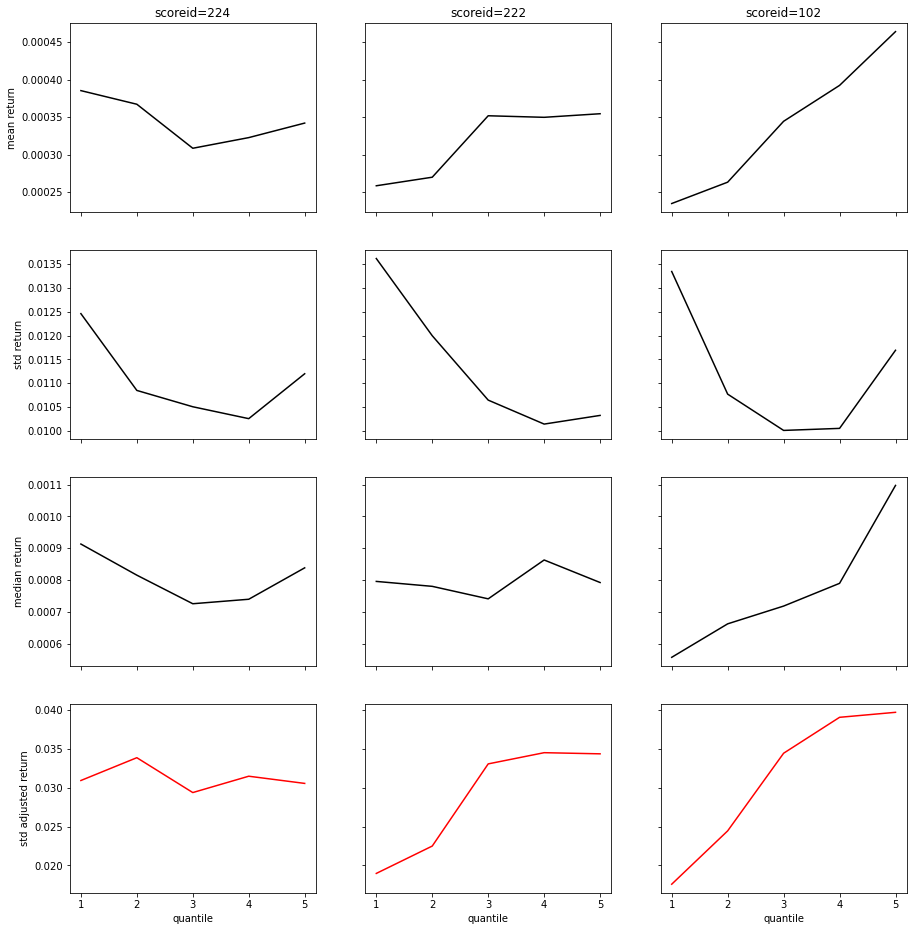

In [25]:
fig,axs = plt.subplots(4,3,figsize=(15,16), sharey='row', sharex=True)
for i in range(n_scoreid):
	axs[0,i].plot(quantiles, np.mean(stat_mean[i,:,:], axis=0), c = 'black')
	axs[1,i].plot(quantiles, np.mean(stat_std[i,:,:], axis=0),  c = 'black')
	axs[2,i].plot(quantiles, np.mean(stat_med[i,:,:], axis=0),  c = 'black')
	axs[3,i].plot(quantiles, np.mean(stat_mean[i,:,:], axis=0)/np.mean(stat_std[i,:,:], axis=0), c = 'red')
	axs[0,i].set_title('scoreid=%d'%scoreids[i])
	axs[3,i].set_xlabel('quantile')
axs[0,0].set_ylabel('mean return')
axs[1,0].set_ylabel('std return')
axs[2,0].set_ylabel('median return')
axs[3,0].set_ylabel('std adjusted return')

plt.show()

* High quantile of 222, 102 have highest standard deviation adjusted return during 2013-2020. 

## 1b. Is one factor consistently superior?
* No, it is possile for each of them to have the best performance in one specific year.

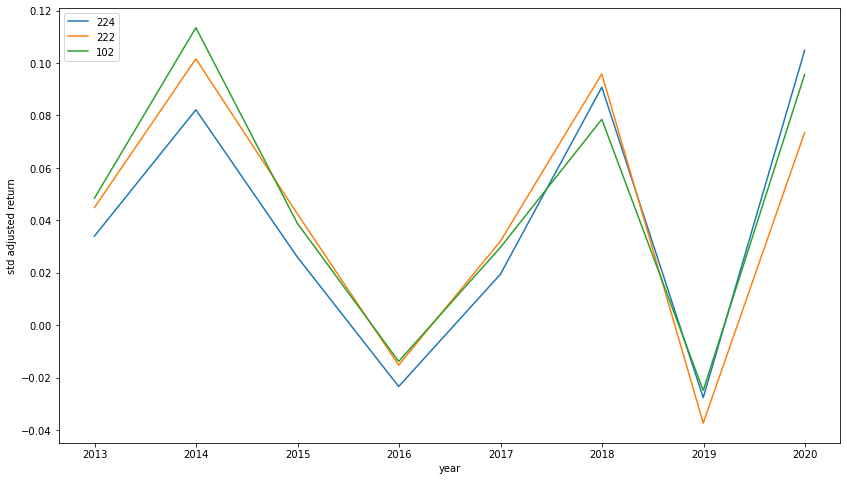

In [26]:
# change with time quantile = 5, scoreid = 102, 222, 224
data_224 = data_sameperiod.loc[(data_sameperiod['scoreid'] == 224) & (data_sameperiod['quantile'] == 5)]
data_222 = data_sameperiod.loc[(data_sameperiod['scoreid'] == 222) & (data_sameperiod['quantile'] == 5)]
data_102 = data_sameperiod.loc[(data_sameperiod['scoreid'] == 102) & (data_sameperiod['quantile'] == 5)]
time_freq = 'Y'
data_adjreturn_224 = data_224.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].mean()/\
					data_224.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].std()
data_adjreturn_222 = data_222.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].mean()/\
					data_222.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].std()
data_adjreturn_102 = data_102.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].mean()/\
					data_102.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].std()
# plot
%matplotlib inline
# widget inline
fig,axs = plt.subplots(figsize=(14,8))
xs = data_224.groupby(pd.Grouper(key='date', axis=0, freq=time_freq))['log_rt'].mean().index
axs.plot(xs, data_adjreturn_224, label='224')
axs.plot(xs, data_adjreturn_222, label='222')
axs.plot(xs, data_adjreturn_102, label='102')
axs.set_xlabel('year')
axs.set_ylabel('std adjusted return')
axs.legend()
plt.show()

## 2. Allocation Model
Markowitz model: 
* weight of assets, $w_1,w_2, ..., w_n$;
* mean returns are $\mu_1, \mu_2, ..., \mu_n$; 

thus the total expected return is $\rho = \mu^T w$ and the risk is $w^T C w$ where $C$ is the covariance matrix.
There exist an **efficient frontier** in the return vs std plot.
![alt text](efficientfrontier_edit.png "Efficient Frontier")


## Derivation of efficient frontier
The problem can be written as :
* minimize variance $w^T C w$ suject to constraints:
* $w^T \cdot 1_n = 1$
* $w^T \cdot R = r_p$

where $r_p$ is the total return of portfolio. 
* Set up Lagrangian and solve to express $w$ in terms of $R, C, r_p$
* Substituding for $w$ gives us the efficient frontier parabola:
$\sigma_p^2 = \frac{a-2br_p+cr_p^2}{ac-b^2}$
where $a=R^T\cdot V^{-1}\cdot R, b = R^T \cdot C^{-1}\cdot 1_n, c = 1_n^T \cdot C^{-1} \cdot 1_n$.

([FromBook](https://stanford.edu/~ashlearn/RLForFinanceBook/EfficientFrontier.pdf) )

## If we treate each segment and quantile of each factor as one type of assset, the total number of assets would be 165. Next we can get the efficient frontier of a portfolio with 165 assets.

In [195]:
# save the return of all types of assets in one dataframe
returns = pd.DataFrame()
for i in range(n_scoreid):
	for j in range(n_segmentid):
		for k in range(n_quantile):
			scoreid = scoreids[i]
			segmentid = segmentids[j]
			quantile = quantiles[k]
			data_selected = select_data(scoreid=scoreid, segmentid=segmentid, quantile=quantile, \
						   data = data_sameperiod)['log_rt'].values
			returns['%d_%d_%d'%(scoreid, segmentid, quantile)] = data_selected
returns = returns.to_numpy().T
print(returns.shape)

(165, 1908)


Random sampling the weight, the efficient frontier does not appear because of the insufficient number of samples for large parameter space(165 dimensions).

In [196]:
# random weight
def rand_weight(n):
	k = np.random.uniform(0, 1, n)
	return(k/sum(k))

def rand_portfolio(returns): 
	R = np.asmatrix(np.mean(returns, axis=1)) # R is mean returns of one asset
	W = np.asmatrix(rand_weight(returns.shape[0])) # weight
	C = np.asmatrix(np.cov(returns))
	# cal total return and std
	mu = W*R.T
	sigma = np.sqrt(W * C * W.T)
	if sigma > 1.5:
		return(rand_portfolio(returns))
	return(mu, sigma, W)
# %matplotlib inline
mus = []
sigmas = []
wts = []
for i in range(10000):
	mu, sigma, W = rand_portfolio(returns)
	mus.append(mu)
	sigmas.append(sigma)
	wts.append(W)
fig,ax = plt.subplots(figsize=(14,8))
ax.scatter(sigmas, mus, marker='o', s=10)
ax.set_xlabel('Std')
ax.set_ylabel('Total return')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Solve for efficient frontier
Using cvsopt.solvers while solves for optimal x in:
* minimize $ \frac{1}{2}*x^T*P*x + q^T*x$  
* subject to $G*x <= h$ 
* $A*x = b.$ 

which is similar to 
* minimize $ -\lambda R^T w + w^T C w$
* $w_i >= 0$
* $\sum w_i = 1$

In [197]:
solvers.options['show_progress'] = False
def optimal_portfolio(returns):
	n = len(returns)
	returns = np.asmatrix(returns)
	
	N = 100
	lambdas = [10**(5.0*t/N - 1.0) for t in range(N)]
	
	# to cvxopt matrices
	S = opt.matrix(np.cov(returns))
	ret_vec = opt.matrix(np.mean(returns, axis=1))
	
	# G,h,A,b
	G = -opt.matrix(np.eye(n)) # G*x <= h, w0, .. wn >=0 
	h = opt.matrix(0.0, (n,1))
	A = opt.matrix(1.0, (1,n)) # A*x = b, w0=...wn = 1
	b = opt.matrix(1.0)
	
	# use opt solvers cal efficient frontier
	
	portfolios = [solvers.qp(lbs*S, -ret_vec, G, h, A, b)['x'] for lbs in lambdas]
	returns_oncurve = [blas.dot(ret_vec, x) for x in portfolios]
	risks_oncurve = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
	return(returns_oncurve, risks_oncurve, portfolios)
returns_oncurve, risks_oncurve, portfolios= optimal_portfolio(returns)

## Get the weight with best performance(return/std)

In [198]:
# find sharp ratio maximum
kmax = 0
imax1 = -1
imax2 = -1
for i in range(len(mus)):
	if mus[i]/sigmas[i] > kmax:
		kmax = mus[i]/sigmas[i]
		imax1 = i
for i in range(len(returns_oncurve)):
	if returns_oncurve[i]/risks_oncurve[i] > kmax:
		kmax = returns_oncurve[i]/risks_oncurve[i]
		imax2 = i
kmax = kmax.sum()
if imax2 != -1:
	wt = portfolios[imax2]
elif imax1 != -1:
	wt = wts[imax1]
else:
	print('error: no kmax found')
xs = np.linspace(0, 1.5, 150)
ys = xs*kmax

# print best portfolio
R = np.asmatrix(np.mean(returns, axis=1))
C = np.asmatrix(np.cov(returns))
W = np.asmatrix(np.sum(wt, axis=1))
mu = W*R.T
sigma = np.sqrt(W * C * W.T)
print(max(wt), sigma, mu)
print(wt)


0.6462060198283748 [[0.00789595]] [[0.00068686]]
[ 2.56e-08]
[ 3.25e-08]
[ 3.38e-08]
[ 3.45e-08]
[ 2.83e-08]
[ 2.99e-08]
[ 1.78e-08]
[ 1.86e-08]
[ 1.88e-08]
[ 2.17e-08]
[ 4.33e-08]
[ 7.26e-08]
[ 6.66e-08]
[ 7.34e-08]
[ 1.33e-07]
[ 5.98e-08]
[ 1.07e-07]
[ 2.11e-07]
[ 1.40e-07]
[ 1.13e-07]
[ 1.99e-07]
[ 2.44e-07]
[ 1.28e-07]
[ 2.36e-07]
[ 1.44e-07]
[ 1.13e-07]
[ 3.06e-07]
[ 1.02e-07]
[ 8.84e-08]
[ 2.53e-08]
[ 4.50e-08]
[ 1.16e-07]
[ 6.54e-08]
[ 6.04e-08]
[ 6.92e-08]
[ 4.98e-08]
[ 7.63e-08]
[ 7.18e-08]
[ 4.44e-07]
[ 1.96e-07]
[ 5.73e-02]
[ 8.34e-08]
[ 5.95e-08]
[ 3.62e-08]
[ 9.73e-08]
[ 1.22e-07]
[ 8.74e-08]
[ 5.03e-08]
[ 7.86e-08]
[ 1.33e-07]
[ 7.36e-08]
[ 9.11e-02]
[ 9.32e-07]
[ 3.96e-07]
[ 1.16e-06]
[ 3.82e-08]
[ 2.48e-08]
[ 2.85e-08]
[ 3.64e-08]
[ 5.20e-08]
[ 1.36e-08]
[ 1.84e-08]
[ 1.88e-08]
[ 2.02e-08]
[ 1.86e-08]
[ 5.50e-08]
[ 5.81e-08]
[ 6.03e-08]
[ 9.33e-08]
[ 1.11e-07]
[ 1.53e-07]
[ 1.42e-07]
[ 1.58e-07]
[ 7.73e-08]
[ 1.01e-07]
[ 5.63e-08]
[ 9.52e-08]
[ 1.02e-07]
[ 7.42e-02]
[ 6

In [199]:
%matplotlib widget
# widget inline
fig,ax = plt.subplots(figsize=(14,8))
ax.scatter(sigmas, mus, marker='o', s=10)
ax.plot(risks_oncurve, returns_oncurve, 'y-o', label = 'optimal solved')
ax.plot(xs, ys, c='orange', label='tangency')
ax.set_xlabel('Std')
ax.set_ylabel('Total return')
ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Build portfolio on the top 8 weighted assets.

In [202]:
# sort asset based on weight
df = pd.DataFrame()
df['wt'] = wt
df = df.sort_values(by='wt', ascending=False)
print(df.head(10))
selected_indexs = df.head(8).index
df_select = df.iloc[0:8,:].copy()
selected_returns = returns[selected_indexs,:]
print(selected_returns.shape)
df_scoreid = []
df_segmentid = []
df_quantile = []
for i_index in selected_indexs:
	i_scoreid = i_index//55
	i_segmentid = (i_index-i_scoreid*55)//5
	i_quantile = i_index-i_scoreid*55-i_segmentid*5
	df_scoreid.append(scoreids[i_scoreid])
	df_segmentid.append(segmentids[i_segmentid])
	df_quantile.append(quantiles[i_quantile])
df_select['scoreid'] = df_scoreid
df_select['segmentid'] = df_segmentid
df_select['quantile'] = df_quantile
print(df_select.head(8))

           wt
83   0.646206
51   0.091058
108  0.076499
78   0.074170
40   0.057308
105  0.038067
129  0.013415
162  0.003051
107  0.000139
79   0.000066
(8, 1908)
           wt  scoreid  segmentid  quantile
83   0.646206      222       1015         4
51   0.091058      224       1020         2
108  0.076499      222       1020         4
78   0.074170      222       1014         4
40   0.057308      224       1018         1
105  0.038067      222       1020         1
129  0.013415      102       1013         5
162  0.003051      102       1020         3


In [190]:
mus = []
sigmas = []
wts = []
for i in range(10000):
	mu, sigma, W = rand_portfolio(selected_returns)
	mus.append(mu)
	sigmas.append(sigma)
	wts.append(W)
fig,ax = plt.subplots(figsize=(14,8))
ax.scatter(sigmas, mus, marker='o', s=10)
ax.set_xlabel('Std')
ax.set_ylabel('Total return')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [192]:
returns_oncurve, risks_oncurve, portfolios= optimal_portfolio(selected_returns)
# find sharp ratio maximum
kmax = 0
imax1 = -1
imax2 = -1
for i in range(len(mus)):
	if mus[i]/sigmas[i] > kmax:
		kmax = mus[i]/sigmas[i]
		imax1 = i
for i in range(len(returns_oncurve)):
	if returns_oncurve[i]/risks_oncurve[i] > kmax:
		kmax = returns_oncurve[i]/risks_oncurve[i]
		imax2 = i
kmax = kmax.sum()
if imax2 != -1:
	wt = portfolios[imax2]
elif imax1 != -1:
	wt = wts[imax1]
else:
	print('error: no kmax found')
xs = np.linspace(0, 1.5, 150)
ys = xs*kmax

# print best portfolio
R = np.asmatrix(np.mean(selected_returns, axis=1))
C = np.asmatrix(np.cov(selected_returns))
W = np.asmatrix(np.sum(wt, axis=1))
mu = W*R.T
sigma = np.sqrt(W * C * W.T)
print(max(wt), sigma, mu)
print(wt)
%matplotlib widget
# widget inline
fig,ax = plt.subplots(figsize=(14,8))
ax.scatter(sigmas, mus, marker='o', s=10)
ax.plot(risks_oncurve, returns_oncurve, 'y-o', label = 'optimal solved')
ax.plot(xs, ys, c='orange', label='tangency')
ax.set_xlabel('Std')
ax.set_ylabel('Total return')
ax.legend()
plt.show()

0.6445950218684131 [[0.00789657]] [[0.00068691]]
[ 6.45e-01]
[ 8.24e-02]
[ 7.18e-02]
[ 7.32e-02]
[ 5.70e-02]
[ 3.77e-02]
[ 1.57e-02]
[ 1.76e-02]



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Performance
* Use the data from this year to train and get weight
* Calculate performance on next year data

In [237]:
data_sameperiod['year'] = data_sameperiod['date'].dt.year
def get_returns(data):
	returns = pd.DataFrame()
	for i in range(n_scoreid):
		for j in range(n_segmentid):
			for k in range(n_quantile):
				scoreid = scoreids[i]
				segmentid = segmentids[j]
				quantile = quantiles[k]
				data_selected = select_data(scoreid=scoreid, segmentid=segmentid, quantile=quantile, \
							   data = data)['log_rt'].values
				returns['%d_%d_%d'%(scoreid, segmentid, quantile)] = data_selected
	returns = returns.to_numpy().T
	return(returns)
		
def yearly_dynamic(mode):
	wts = []
	mus = []
	sigmas = []
	for year in range(2012, 2018):
		year_data = data_sameperiod.loc[data_sameperiod['year'] == year]
		returns = get_returns(year_data)
		returns_oncurve, risks_oncurve, portfolios= optimal_portfolio(returns)
		# get optimal wt
		kmax = 0
		imax = -1
		for i in range(len(returns_oncurve)):
			ki = returns_oncurve[i]/risks_oncurve[i]
			if ki > kmax:
				kmax = ki
				imax = i
		wt_selected = portfolios[imax]
		wts.append(wt_selected)
		# performance
		if mode == 'test':
			target_return = get_returns(year_data)
		else:
			next_year_data = data_sameperiod.loc[data_sameperiod['year'] == year + 1]
			target_return = get_returns(next_year_data)
		R = np.asmatrix(np.mean(target_return, axis=1))
		C = np.asmatrix(np.cov(target_return))
		W = np.asmatrix(np.sum(wt_selected, axis=1))
		mu = W*R.T
		sigma = np.sqrt(W * C * W.T)
		mus.append(mu)
		sigmas.append(sigma)
	return(mus, sigmas, wts)
mus, sigmas, wts = yearly_dynamic('test')
mus_pred, sigmas_pred, wts_pred = yearly_dynamic('predict')

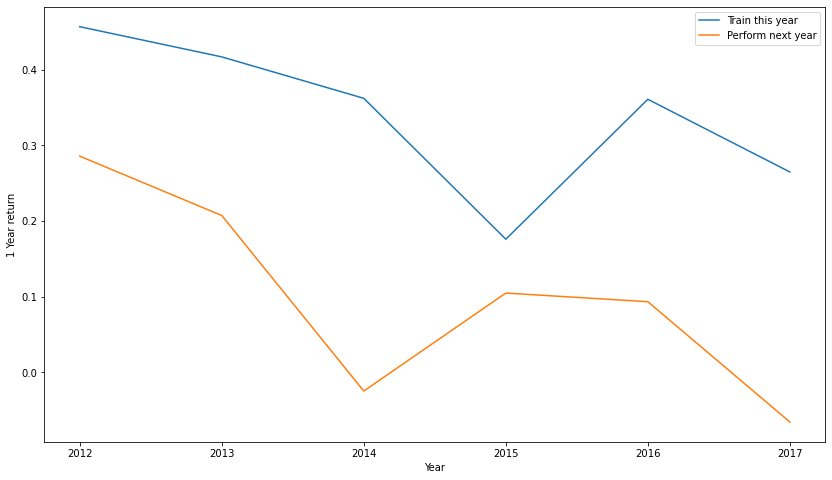

In [259]:
%matplotlib inline
# widget inline
years = np.arange(2012, 2018)
fig,ax = plt.subplots(figsize=(14,8))
ax.plot(years, np.sum(mus, axis=1)*250, label='Train this year')
ax.plot(years, np.sum(mus_pred, axis=1)*250, label='Perform next year')
ax.set_xlabel('Year')
ax.set_ylabel('1 Year return')
ax.legend()
plt.show()

## weight change

In [254]:
wt_list = []
for i in range(len(wts)):
	iwt = []
	for j in range(165):
		iwt.append(wts[i][j])
	wt_list.append(iwt)
wt_array = np.array(wt_list).T

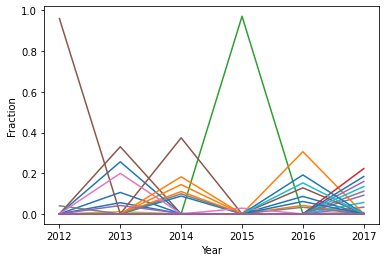

In [257]:
for i in range(len(wt_array)):
	plt.plot(years, wt_array[i])
plt.ylabel('Fraction')
plt.xlabel('Year')
plt.show()

## Next:
* Add more constraints: set threshold for the top investment e.g. $w_i < 30\%$
* Change the period of the dynamic model, use $R, C$ from last period e.g. 0.5, 2 year
* Add more points on the efficient frontier